In [1]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

from flow_matching.solver import ODESolver
from flow_matching.utils import ModelWrapper
from torch.distributions.normal import Normal


class Flow(ModelWrapper):
    def __init__(self, dim=2, h=64):
        super().__init__(None)
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + 1, h), torch.nn.ELU(),
            torch.nn.Linear(h, dim))

    def forward(self, x, t):
        t = t.view(-1, 1).expand(*x.shape[:-1], -1)
        return self.net(torch.cat((t, x), -1))

dim=2
h=64

velocity_model = Flow()

# Optimize the model parameters s.t. model(x_t, t) = ut(Xt)
batch_size, data_dim = 200, 2

x_0 = torch.randn(batch_size, data_dim) # Specify the initial condition

solver = ODESolver(velocity_model=velocity_model)
num_steps = 100
x_1 = solver.sample(x_init=x_0, method='midpoint', step_size=1.0 / num_steps)

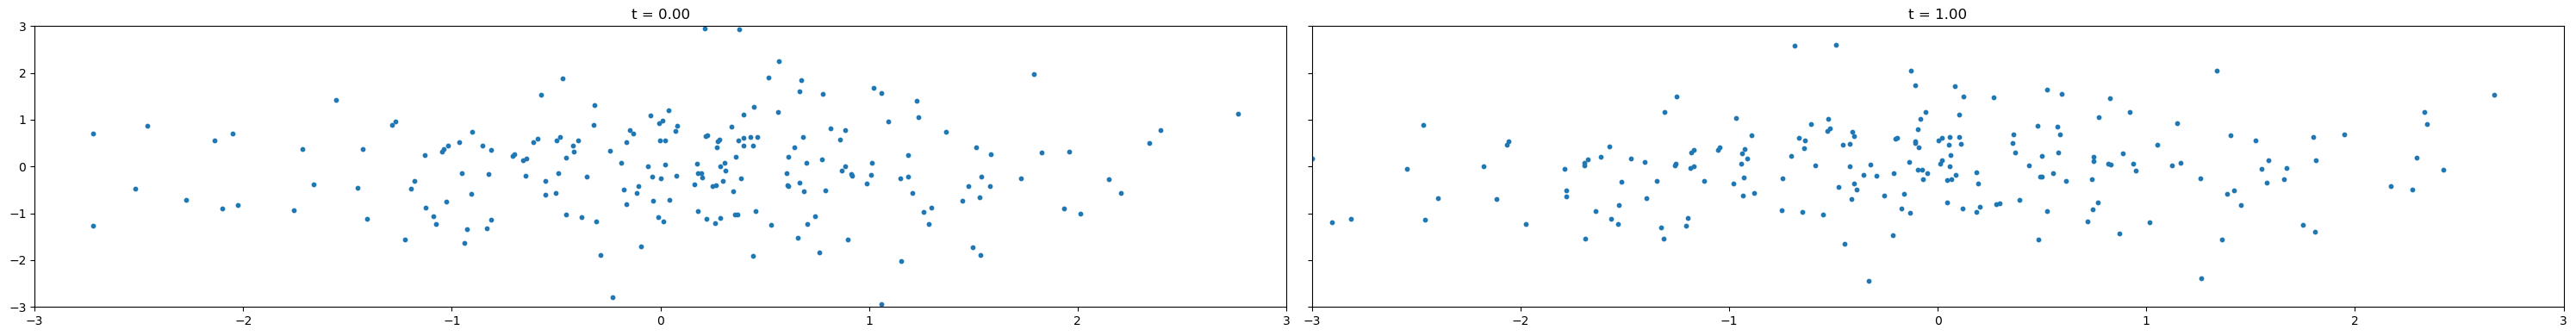

In [2]:
# x = torch.randn(300, 2)
from matplotlib import pyplot as plt


x = [x_0, x_1]
n_steps = 1
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x[0].detach()[:, 0], x[0].detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(1, n_steps+1):
    x = x[i]
    # x = flow1.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i].set_title(f't = {time_steps[i]:.2f}')

plt.tight_layout()
plt.show()

In [3]:
optimizer = torch.optim.Adam(velocity_model.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1 = Tensor(make_moons(256, noise=0.05)[0])
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss_fn(velocity_model(x_t, t), dx_t).backward()
    optimizer.step()

In [4]:
gaussian_log_density

NameError: name 'gaussian_log_density' is not defined

In [15]:
data_dim = (2,)

x_1 = torch.randn(batch_size, *data_dim) # Point X1 where we wish to compute log p1(x)
# Define log p0(x)
gaussian_log_density = Normal(torch.zeros(size=data_dim), torch.ones(size=data_dim)).log_prob
solver = ODESolver(velocity_model=velocity_model)
num_steps = 100
x_0, log_p1 = solver.compute_likelihood(
x_1=x_1,
method='midpoint',
step_size=1.0 / num_steps,
log_p0=gaussian_log_density
)

torch.Size([200, 2]) torch.Size([2, 200])


RuntimeError: The size of tensor a (2) must match the size of tensor b (200) at non-singleton dimension 1